In [1226]:
import matplotlib.pyplot as plot
import numpy as np
from numba import njit, jit
import matplotlib.pyplot as plt

In [157]:
def r0_p(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)+np.sin(phi)) / (eta2*np.cos(alpha))
    return r0

def r0_m(phi,alpha,beta,eta1,eta2):
    r0 = beta*eta1*(-np.cos(alpha+phi)-np.sin(phi)) / (eta2*np.cos(alpha))
    return r0

def r0_1(phi,alpha,beta,eta1,eta2):
    return np.ones_like(phi)
def r0_M1(phi,alpha,beta,eta1,eta2):
    return -np.ones_like(phi)
def r0_0(phi,alpha,beta,eta1,eta2):
    return np.zeros_like(phi)

def phi0(phi,alpha,beta,eta1,eta2,r):
    # eta1 delta peak의 분포 차
    r0 = r(phi,alpha,beta,eta1,eta2)
    dpsi2 = - 1/2 * (1+r0**2)*(eta2*r0*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha+phi)+beta**2*eta1**2*np.sin(alpha+2*phi))
    dpsi1 = - 1/2 * (2)*(eta1*np.sin(alpha)+2*beta*eta1*eta2*r0*np.sin(alpha-phi)+beta**2*eta2**2*r0**2*np.sin(alpha-2*phi))
    dphi = dpsi2 - dpsi1
    return dphi    

def F_Jm(r,phi,alpha,beta,eta1,eta2):
    # beta = eta2*r*(-np.cos(alpha+phi) - np.sin(phi))/ (eta1 * np.cos(alpha+2*phi))
    drdr = -r**2*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha)) + r*(1 - r**2)*(2*beta*eta1*eta2*np.cos(alpha + phi) + 2*eta2**2*r*np.cos(alpha))/2 + (1 - r**2)*(beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi) + eta2**2*r**2*np.cos(alpha))/2
    drdphi = r*(1 - r**2)*(-2*beta**2*eta1**2*np.sin(alpha + 2*phi) - 2*beta*eta1*eta2*r*np.sin(alpha + phi))/2
    dphidr = 2*beta**2*eta2**2*r*np.sin(alpha - 2*phi) + 2*beta*eta1*eta2*np.sin(alpha - phi) - r*(beta**2*eta1**2*np.sin(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.sin(alpha + phi) + eta2**2*r**2*np.sin(alpha)) + (-r**2/2 - 1/2)*(2*beta*eta1*eta2*np.sin(alpha + phi) + 2*eta2**2*r*np.sin(alpha))
    dphidphi = -2*beta**2*eta2**2*r**2*np.cos(alpha - 2*phi) - 2*beta*eta1*eta2*r*np.cos(alpha - phi) + (-r**2/2 - 1/2)*(2*beta**2*eta1**2*np.cos(alpha + 2*phi) + 2*beta*eta1*eta2*r*np.cos(alpha + phi))
    J = np.array([[drdr,drdphi],[dphidr,dphidphi]])
    D = np.linalg.det(J)
    tau = np.trace(J)
    discriminant = tau**2 - 4*D
    return np.linalg.det(J),np.trace(J),discriminant
def Linear_analysis(Det,Trace,Delta):
    D_sign = np.sign(Det)
    T_sign = np.sign(Trace)
    Delta_sign = np.sign(Delta)
    if Delta_sign == 1:
        C = 'node'
    elif Delta_sign == -1:
        C = 'spiral'
    else:
        C = 'Degenerate'
    if D_sign == -1:
        return 'Saddle'
    elif D_sign == 0:
        return 'Line/ need to analysis nonlinearity'
    
    if T_sign == 1:
        B = 'Stable'
    elif T_sign == -1:
        B = 'Unstable'
    else:
        return 'Center/ Need to analysis nonlinearity'
    return B + ' ' + C
    


## 시뮬레이션과 OA ansatz를 비교

In [158]:
@jit(nopython=True)
def RK4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n,len(y0)))
    y[0] = y0

    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3 = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
    return y
args = ()
@jit(nopython=True)
def H_Chimera(u,t=0,args = args):
    r1 = u[0]
    r2 = u[1]
    phi = u[2]
    beta,alpha,eta1,eta2 = args
    dr1 = 1/2 * r1* (1-r1**2)*(eta1**2 * r1**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r1*r2*np.cos(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.cos(alpha + 2*phi))
    dr2 = 1/2 * r2* (1-r2**2)*(eta2**2 * r2**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r2*r1*np.cos(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.cos(alpha - 2*phi))
    dpsi1 = -1/2 * (1+r1**2)*(eta1**2 * r1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r1*r2*np.sin(alpha+phi) + beta**2 * eta2**2 * r2**2 * np.sin(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r2**2)*(eta2**2 * r2**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r2*r1*np.sin(alpha-phi) + beta**2 * eta1**2 * r1**2 * np.sin(alpha - 2*phi))
    dphi = dpsi1 - dpsi2
    return np.array([dr1,dr2,dphi])


@jit(nopython=True)
def myFun2(u,t=0,args = args):
    r = u[0]
    phi = u[1]
    beta,alpha,eta1,eta2 = args
    dr = 1/2 * r* (1-r**2)*(eta2**2 * r**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r*np.cos(alpha+phi) + beta**2 * eta1**2 * np.cos(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r**2)*(eta2**2 * r**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r*np.sin(alpha+phi) + beta**2 * eta1**2 * np.sin(alpha + 2*phi))
    dpsi1 = -1/2 * (2)*(eta1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r *np.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * np.sin(alpha-2*phi))
    dphi =  dpsi2 - dpsi1
    return np.array([dr,dphi])

def myFun3(u,t=0,args = args):
    r = u[0]
    phi = u[1]
    beta,alpha,eta1,eta2 = args
    dr = 1/2 * r* (1-r**2)*(eta2**2 * r**2 * np.cos(alpha) + 2 * beta*eta1*eta2*r*np.cos(alpha+phi) + beta**2 * eta1**2 * np.cos(alpha + 2*phi))
    dpsi2 = -1/2 * (1+r**2)*(eta2**2 * r**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r*np.sin(alpha+phi) + beta**2 * eta1**2 * np.sin(alpha + 2*phi))
    dpsi1 = -1/2 * (2)*(eta1**2 * np.sin(alpha) + 2 * beta*eta1*eta2*r *np.sin(alpha-phi) + beta**2 * eta2**2 * r**2 * np.sin(alpha-2*phi))
    dphi =  dpsi2 - dpsi1
    return np.array([dr,dphi])

In [159]:
a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag
@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag,db1.real,db1.imag,da2.real,da2.imag,db2.real,db2.imag])


a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag
@jit(nopython=True)
def dZ_dt(Zs,t,alpha,beta,eta1,eta2):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    Z11 = 1/2 * (np.conj(a1)+np.conj(b1)) + eta1/2 * (np.conj(a1)-np.conj(b1))
    Z12 = 1/2 * (np.conj(a2)+np.conj(b2)) + eta2/2 * (np.conj(a2)-np.conj(b2))
    H1 = (Z11**2 + 2*beta*Z11*Z12 + beta**2*Z12**2)
    H2 = (Z12**2 + 2*beta*Z11*Z12 + beta**2*Z11**2)
    
    da1 = 1/2 *(np.conj(H1)*np.conj(a1)*np.exp(1j*alpha) - H1*a1**3*np.exp(-1j*alpha) )
    db1 = 1/2 *(np.conj(H1)*np.conj(b1)*np.exp(1j*alpha) - H1*b1**3*np.exp(-1j*alpha) )
    da2 = 1/2 *(np.conj(H2)*np.conj(a2)*np.exp(1j*alpha) - H2*a2**3*np.exp(-1j*alpha) )
    db2 = 1/2 *(np.conj(H2)*np.conj(b2)*np.exp(1j*alpha) - H2*b2**3*np.exp(-1j*alpha) )
    return np.array([da1.real,da1.imag, db1.real,db1.imag, da2.real,da2.imag, db2.real,db2.imag])


def to_complex(Zs):
    a1real,a1imag,b1real,b1imag,a2real,a2imag,b2real,b2imag = Zs.T
    a1 = a1real + 1j*a1imag
    a2 = a2real + 1j*a2imag
    b1 = b1real + 1j*b1imag
    b2 = b2real + 1j*b2imag
    return a1,b1,a2,b2

In [1230]:
import functools
import numpy as np
from scipy.optimize import root_scalar


def _vectorize_float(f):
    vectorized = np.vectorize(f, otypes=[float], signature="(),()->()")

    @functools.wraps(f)
    def wrapper(*args):
        return vectorized(*args)

    return wrapper


class MixtureDistribution:
    def __init__(self, distributions, weights):
        self._distributions = list(distributions)
        self._weights = list(weights)

        if not (all(w >= 0 for w in self._weights) and sum(self._weights) == 1):
            raise ValueError("Invalid weight vector.")

        if len(self._distributions) != len(self._weights):
            raise ValueError("Mixtures and weights must have the same length.")

        if len(self._distributions) < 2:
            raise ValueError("Must have at least two component distributions.")

    @_vectorize_float
    def pdf(self, x):
        return sum(w * d.pdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def cdf(self, x):
        return sum(w * d.cdf(x) for w, d in zip(self._weights, self._distributions))

    @_vectorize_float
    def ppf(self, p):
        bracket = [min(dist.ppf(p) for dist in self._distributions),
                   max(dist.ppf(p) for dist in self._distributions)]

        r = root_scalar(
            f=lambda x: self.cdf(x) - p,
            fprime=self.pdf,
            bracket=bracket,
            x0=0
        )
        assert r.converged
        return r.root
    # https://www.jamesatkins.com/posts/quantile-function-of-mixture-distributions-in-python/

In [1231]:

@jit(nopython=True)
def RK4_ZZ(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y[0] = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y[i], t[i], *args)
        k2,_,_,_,_ = f(y[i] + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y[i] + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y[i] + k3 * h, t[i] + h, *args)
        y[i + 1] = y[i] + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return y,(Z1as,Z1bs,Z2as,Z2bs)

@jit(nopython=True)
def RK4_ZZ2(f, y0, t, args=()):
    n = len(t)
    Etheta = np.exp(1j*y0)
    Na = args[0]
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    Z1as = np.zeros(n,dtype=np.complex64)
    Z1bs = np.zeros(n,dtype=np.complex64)
    Z2as = np.zeros(n,dtype=np.complex64)
    Z2bs = np.zeros(n,dtype=np.complex64)

    Z1as[0] = Z1a
    Z2as[0] = Z2a
    Z1bs[0] = Z1b
    Z2bs[0] = Z2b
    
    y = y0
    
    for i in range(n - 1):
        h = t[i + 1] - t[i]
        k1,Z1a,Z1b,Z2a,Z2b = f(y, t[i], *args)
        k2,_,_,_,_ = f(y + k1 * h / 2.0, t[i] + h / 2.0, *args)
        k3,_,_,_,_ = f(y + k2 * h / 2.0, t[i] + h / 2.0, *args)
        k4,_,_,_,_ = f(y + k3 * h, t[i] + h, *args)
        y = y + (h / 6.0) * (k1 + 2 * k2 + 2 * k3 + k4)
        Z1as[i+1],Z1bs[i+1],Z2as[i+1],Z2bs[i+1] = Z1a,Z1b,Z2a,Z2b
    return Z1as,Z1bs,Z2as,Z2bs

@jit(nopython=True)
def get_ZE12(Etheta):
    ''' get theta and return r and theta'''
    E1 = Etheta
    E2 = E1**2
    Z1,Z2 = np.mean(E1),np.mean(E2)
    return Z1,Z2

# @jit(nopython=True)
# def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
#     dtheta = np.zeros(Na+Nb)

#     Etheta = np.exp(1j*Theta)
#     EA,EB = Etheta[:Na],Etheta`[Na:]
#     Z1a,Z2a = get_ZE12(EA)
#     Z1b,Z2b = get_ZE12(EB)
#     A = np.exp(-1j*alpha)
#     EA,EB = np.conjugate(EA), np.conjugate(EB)
#     ZZa =  (Z1a+beta*Z1b)
#     ZZb =  (Z1b+beta*Z1a)
#     dtheta[:Na] = K*((A*(ZZa**2-Z2a/Na - beta*Z2b/Nb))*EA*EA -(2*A/Na*ZZa)*EA).imag
#     dtheta[Na:] = K*((A*(ZZb**2-Z2b/Nb - beta*Z2a/Na))*EB*EB -(2*A/Nb*ZZb)*EB).imag
#     return dtheta,Z1a,Z1b,Z2a,Z2b

@jit(nopython=True)
def Kuramoto_MF_CHIMERA(Theta,t,Na,Nb,beta,alpha,K):
    dtheta = np.zeros(Na+Nb)

    Etheta = np.exp(1j*Theta)
    EA,EB = Etheta[:Na],Etheta[Na:]
    Z1a,Z2a = get_ZE12(EA)
    Z1b,Z2b = get_ZE12(EB)
    A = np.exp(-1j*alpha)
    EA,EB = np.conjugate(EA), np.conjugate(EB)
    ZZa =  K*(Z1a+beta*Z1b)
    ZZb =  K*(Z1b+beta*Z1a)
    dtheta[:Na] = ((A*(ZZa**2))*EA*EA).imag
    dtheta[Na:] = ((A*(ZZb**2))*EB*EB).imag
    return dtheta,Z1a,Z1b,Z2a,Z2b

In [161]:
# alpha = 0.1
# beta = 0.8
# eta1 = 0.2
# eta2 = 0.05

alpha = 1.5
beta = 0.6
eta1 = 0.4 / 2
eta2 = 0.2 / 2


args = beta,alpha,eta1,eta2

In [162]:
args

(0.6, 1.5, 0.2, 0.1)

In [175]:
t = np.arange(0,5000,0.1)

In [176]:
u0 =  [np.sqrt(0.6),0]
R1,P1 = RK4(myFun2,np.array(u0),t,args=(args,)).T#[:,::1000]
u0 =  [1,np.sqrt(0.6),0]
_,R2,P2 = RK4(H_Chimera,np.array(u0),t,args=(args,)).T#[:,::1000]

In [177]:
A1 = 1
A2 = np.sqrt(0.6)
shift = 0.0 * np.pi

a1 =  A1 *np.exp(0j)
b1 =  a1 * np.exp(np.pi*1j)
a2 =  A2*np.exp(shift*1.0j)
b2 =  a2* np.exp(np.pi*1j)

Zs = RK4(dZ_dt,np.array([a1.real,a1.imag,b1.real,b1.imag,a2.real,a2.imag,b2.real,b2.imag]),t,args=(alpha,beta,eta1,eta2))#[::1000]
a1s,b1s,a2s,b2s = to_complex(Zs)

RZ1 = 1/2 * (np.conj(a1s)+np.conj(b1s)) + eta1/2 * (np.conj(a1s)-np.conj(b1s))
QZ1 = 1/2 * (np.conj(a1s)**2+np.conj(b1s)**2) + eta1/2 * (np.conj(a1s)**2-np.conj(b1s)**2)
RZ2 = 1/2 * (np.conj(a2s)+np.conj(b2s)) + eta2/2 * (np.conj(a2s)-np.conj(b2s))
QZ2 = 1/2 * (np.conj(a2s)**2+np.conj(b2s)**2) + eta2/2 * (np.conj(a2s)**2-np.conj(b2s)**2)

R1s = np.abs(RZ1)
R2s = np.abs(RZ2)
Q1s = np.abs(QZ1)
Q2s = np.abs(QZ2)

(0.0, 0.07858974623796526)

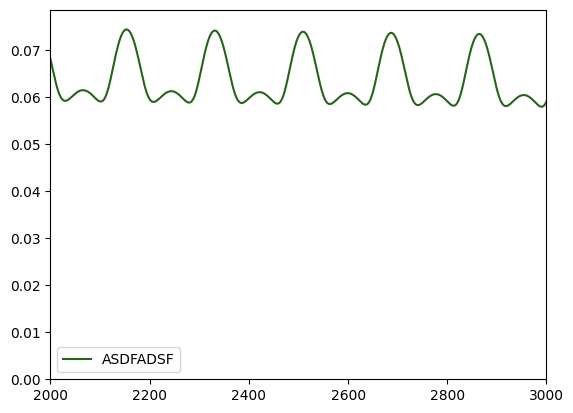

In [180]:
color = plt.cm.PiYG_r(0,alpha=1)
plt.plot(t,eta2*R2,color=color,label='ASDFADSF')
plt.legend()
plt.xlim(2000,3000)
plt.ylim(0,)


In [126]:
plt.plot(np.abs(r1a)**2 )

NameError: name 'r1a' is not defined

In [127]:
plt.plot(np.abs(q1a)- np.abs(r1a)**2)

NameError: name 'q1a' is not defined

ValueError: x and y must have same first dimension, but have shapes (20,) and (20000,)

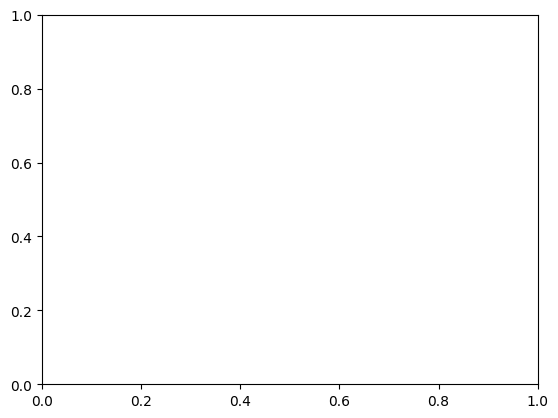

In [128]:
plt.plot(t[::1000],np.angle(RZ1))
plt.plot(t[::1000],np.angle(RZ2))

plt.xlim(5000,7500)

ValueError: x and y must have same first dimension, but have shapes (20,) and (20000,)

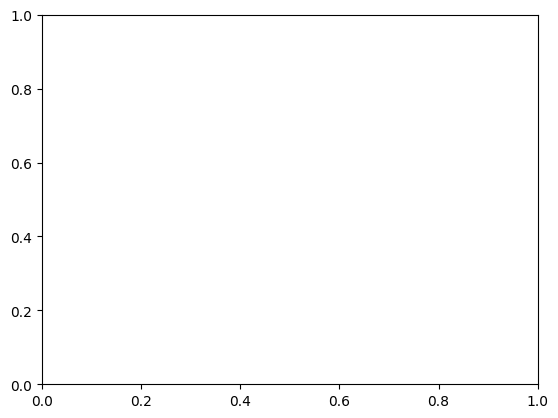

In [129]:
plt.plot(t[::1000],abs(a1s) - abs(b1s))
plt.plot(t[::1000],abs(a2s) - abs(b2s))


ValueError: x and y must have same first dimension, but have shapes (20,) and (20000,)

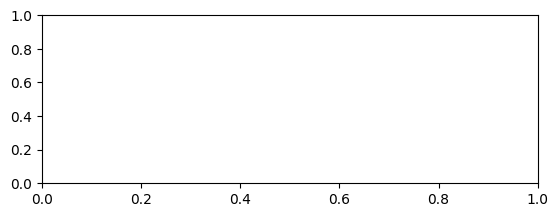

In [130]:
plt.subplot(211)
plt.plot(t[::1000],np.abs(np.abs(a2s) - np.abs(b2s)))
# plt.plot(t,np.abs(np.abs(a1s) - np.abs(b1s)))
plt.subplot(212)
# plt.plot(t[::1000],np.abs(np.abs(np.angle(a2s) - np.angle(b2s)) - np.pi))
plt.plot(t[::1000],(np.cos(np.angle(a2s) - np.angle(b2s))))
# plt.plot(t[::1000],((np.angle(b2s) - np.angle(a1s))))
# plt.xlim(7200,7700)

# plt.loglog()
# plt.plot(t,np.abs(np.angle(a1s) - np.angle(b1s)))

In [ ]:
x =  np.linspace(0,2*np.pi,1000) + 1e-10

In [ ]:
def dist_ab(x,a,b,eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (1/2+eta/2)*(a_+a_.conjugate())+(1/2-eta/2)*(b_+b_.conjugate()))# + np.conj(c_))
    return f

In [ ]:
eta2

0.1

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


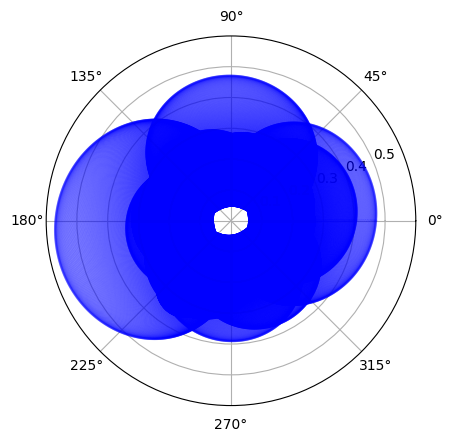

In [ ]:
# plt.plot(x,dist_ab(x,a1s[22][-1],b1s[22][-1],eta1))
index = 28
plt.subplot(projection='polar')
for i in range(1000,20000,2):
    # plt.plot(x,dist_ab(x,a1s[21][i*50],b1s[21][i*50],eta2),color='red')
    # plt.plot(x,dist_ab(x+np.angle(a1s[i]),a1s[i],b1s[i],eta1),color='red',alpha=0.2)
    plt.plot(x,dist_ab(x,a2s[i],b2s[i],eta2),color='blue',alpha=0.2)
    # break
# plt.ylim(0,2)

In [ ]:
eta2

0.05

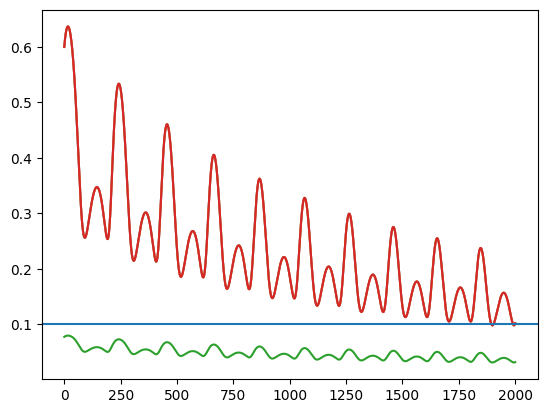

In [ ]:
plt.plot(t,R1**2)
plt.plot(t,R2**2)
plt.plot(t,R2s)
plt.plot(t,Q2s)
# plt.axhline(eta1)
plt.axhline(eta2)

In [ ]:
R2s

array([0.07745967, 0.07832197, 0.07916987, ..., 0.1       , 0.1       ,
       0.1       ])

(0.0, 250.0)

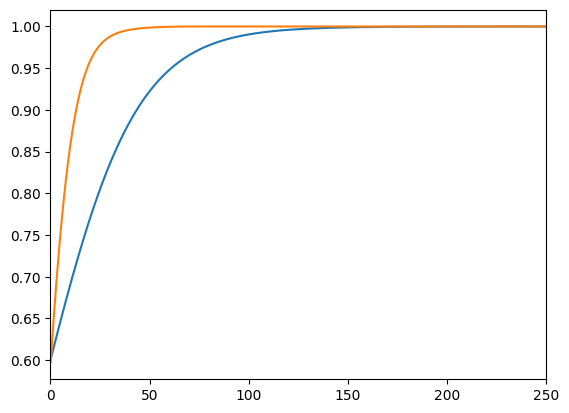

In [ ]:
plt.plot(t,Q2s)
plt.plot(t_,Q2_S)
plt.xlim(0,250)
# plt.plot(t_,Q2_S)

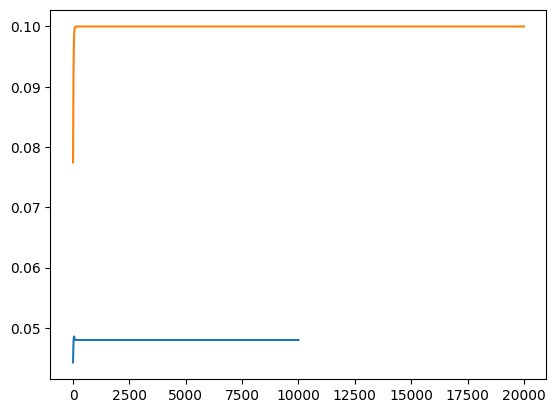

In [ ]:
plt.plot(t_,R2_S)
plt.plot(t[::1000],R2s)
# plt.plot(t_,Q2_S)

In [ ]:
from scipy import stats

In [ ]:
t_ = np.arange(0,1000,0.01)

In [ ]:
eta1,eta2

(0.2, 0.05)

In [ ]:
Q2_S = {}

In [ ]:
eta1

0.2

In [167]:
# eta1 = 0.05
# eta2 = 0.05
sigma1 = 1e-10
sigma2 = 0.50790452
shift = 0*np.pi/8


# m1 = MixtureDistribution([stats.norm(0,sigma1), stats.norm(np.pi,sigma1)], [1/2 + eta1/2, 1/2 - eta1/2])
m2 = MixtureDistribution([stats.norm(0+shift,sigma2), stats.norm(np.pi+shift,sigma2)], [1/2 + eta2/2, 1/2 - eta2/2])

N = 500
ps = (np.arange(N+1)[:-1] + 1)/(N+1)
# theta1 = m1.ppf(ps)
theta1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]

theta2 = m2.ppf(ps)
Theta = np.r_[theta1,theta2]

Q2_init = np.mean(np.exp(2j*theta2))
print(abs(Q2_init),np.angle(Q2_init))

0.600087183786073 -0.00010091215322970427


In [168]:
import numpy as np
from scipy.integrate import cumtrapz
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

def dist_ab(x, a, b, eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (1/2+eta/2)*(a_+a_.conjugate())+(1/2-eta/2)*(b_+b_.conjugate()))
    return f.real  # 확률밀도함수는 실수부만 사용합니다.

# 파라미터 설정
a = a2s[0]
b = b2s[0]
eta = eta2

# x 값 범위 설정
x = np.linspace(-np.pi/2, 3*np.pi/2, 10000)

# 확률 밀도 함수 계산
pdf = dist_ab(x, a, b, eta)

# 수치적 적분을 사용하여 CDF 계산
cdf = cumtrapz(pdf, x, initial=0)
cdf /= cdf[-1]  # 정규화

# CDF를 바탕으로 분위수 함수 구현
quantile_func = interp1d(cdf, x, kind='nearest', fill_value='extrapolate')

quantiles = [0.25, 0.5, 0.75]
quantile_values = quantile_func(ps)


/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46333/2659298270.py:24: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  cdf = cumtrapz(pdf, x, initial=0)


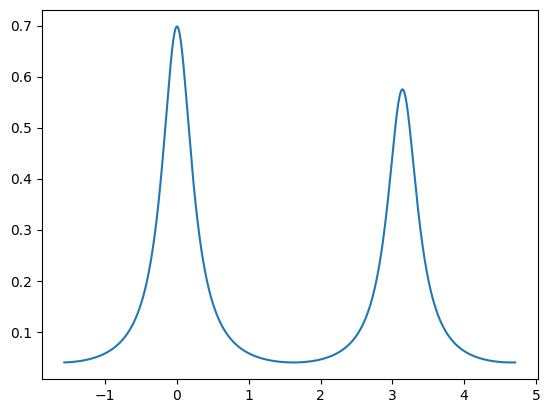

In [169]:
plt.plot(x,pdf)

In [170]:

N = 4000
ps = (np.arange(N+1)[:-1] + 1)/(N+1)

theta1 = np.r_[np.zeros(int((1/2 + eta1/2)*N)),np.pi* np.ones(N - int((1/2 + eta1/2)*N))]
theta2 = quantile_func(ps)
Theta = np.r_[theta1,theta2]

In [171]:
np.abs(np.mean(np.exp(1j*theta2[:int(N*(1+eta2)/2)])))

0.8571633141063403

In [172]:
np.abs(np.mean(np.exp(1j*theta2[int(N*(1+eta2)/2):])))

0.8754831700350915

In [137]:
(len(np.where(theta2<np.pi/2)[0]) - 1000)/N

0.292

In [138]:
len(np.where(theta2>np.pi/2)[0])

1832

In [139]:
x = np.linspace(-np.pi/2,3*np.pi/2,1000)

(array([0.04385533, 0.03986848, 0.03986848, 0.04385533, 0.04385533,
        0.04784218, 0.04784218, 0.05182902, 0.05581587, 0.05980272,
        0.06378957, 0.07176327, 0.08372381, 0.09169751, 0.10365805,
        0.11960544, 0.14352653, 0.17143447, 0.21130295, 0.25515828,
        0.32692154, 0.4146322 , 0.51829025, 0.6139746 , 0.68972472,
        0.68573787, 0.60998775, 0.50632971, 0.40267166, 0.31894785,
        0.25515828, 0.20332925, 0.16744762, 0.13953968, 0.11960544,
        0.10365805, 0.09169751, 0.07973696, 0.07176327, 0.06378957,
        0.05980272, 0.05581587, 0.05182902, 0.04784218, 0.04784218,
        0.04385533, 0.03986848, 0.04385533, 0.03986848, 0.03986848,
        0.03986848, 0.03986848, 0.03986848, 0.03986848, 0.04385533,
        0.03986848, 0.04784218, 0.04385533, 0.05182902, 0.05182902,
        0.05980272, 0.06378957, 0.06777642, 0.07973696, 0.08771066,
        0.10365805, 0.11561859, 0.14352653, 0.17143447, 0.21130295,
        0.26711882, 0.33090839, 0.4146322 , 0.50

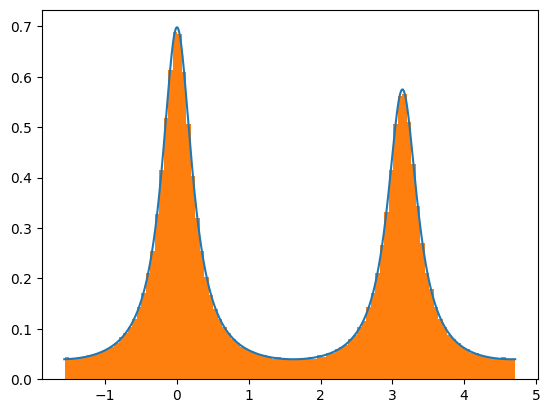

In [140]:
plt.plot(x,np.abs(dist_ab(x,a2s[0],b2s[0],eta2)).real)
plt.hist(theta2,density=True,bins=100)

In [141]:
len(theta2[:int((1/2 + eta2/2)*N)])

2200

In [142]:
int((1/2 + eta2/2)*N)

2200

In [143]:
len(theta2[theta2 > np.pi/2])


1832

(array([2400.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1600.]),
 array([0.        , 0.31415927, 0.62831853, 0.9424778 , 1.25663706,
        1.57079633, 1.88495559, 2.19911486, 2.51327412, 2.82743339,
        3.14159265]),
 <BarContainer object of 10 artists>)

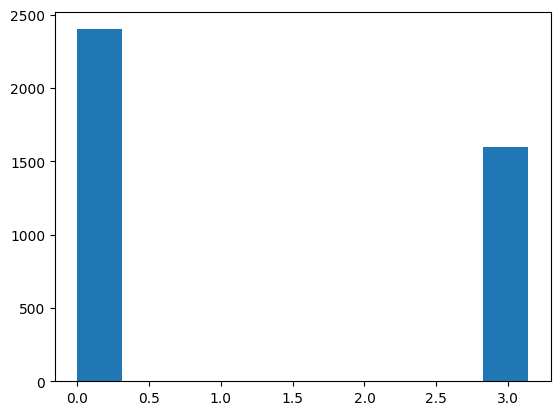

In [144]:
plt.hist(theta1)

In [145]:
(1/2 - eta1/2) *N

1600.0

In [191]:
t_ = np.arange(0,10000,0.1)

In [192]:
nums = []

In [193]:
num = 0
Q2_S = {}

In [194]:
N1 = N2 = N
K = 1
thetas,(Z1as,Z1bs,Z2as,Z2bs) = RK4_ZZ(Kuramoto_MF_CHIMERA,Theta.copy(),t_,args=(N1,N2,beta,alpha,K))
R1_S = np.abs(Z1as)
R2_S = np.abs(Z1bs)
Q1_S = np.abs(Z2as)
Q2_S[num] = np.abs(Z2bs)
nums.append(num)
num+=1


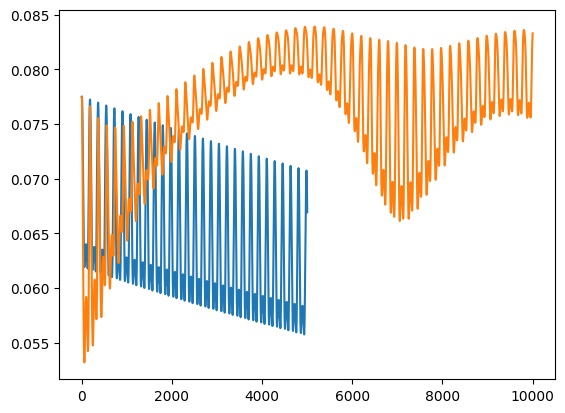

In [207]:
plt.plot(t,R2s)
plt.plot(t_,R2_S)


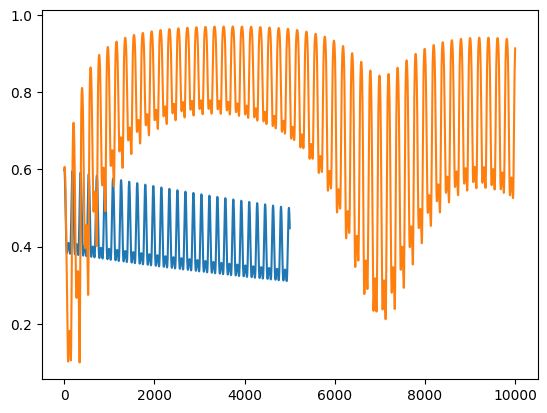

In [195]:
plt.plot(t,Q2s)
# plt.plot(t_,R2_S)
for a in nums:
    plt.plot(t_,Q2_S[a])

In [155]:
r2 = Z1bs/eta2

In [1323]:
r22 = r2*np.exp(1j * np.pi)

(0.0, 1000.0)

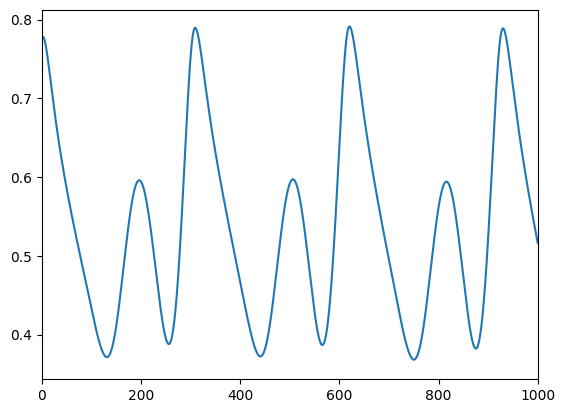

In [1324]:
plt.plot(t_,np.abs(r2))
# plt.plot(t,np.abs(a2s))
plt.xlim(0,1000)

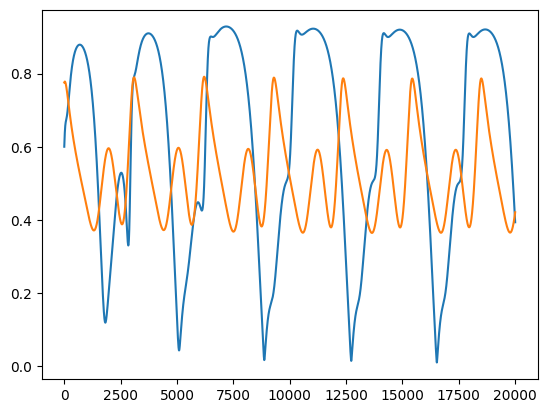

In [1325]:
plt.plot(np.abs(q1a))
plt.plot(np.abs(r2))

In [ ]:
np.sum(np.exp(1j*thetas2[:,N:N+275]),axis=1)**2 - np.sum(np.exp(2j*thetas2[:,N:N+275]),axis=1) - 
np.sum(np.exp(1j*thetas2[:,N:N+275]),axis=1)**2 - np.sum(np.exp(2j*thetas2[:,N:N+275]),axis=1)

SyntaxError: invalid syntax (205568138.py, line 1)

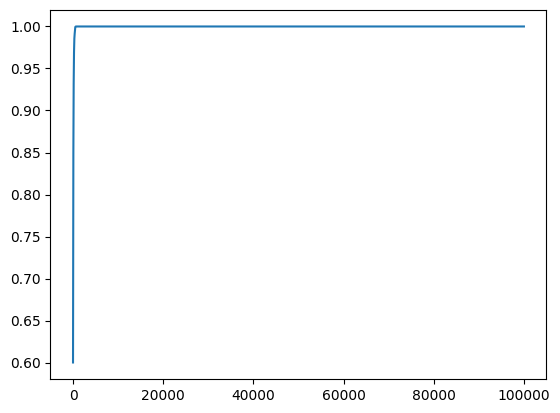

In [ ]:
plt.plot(np.abs(q1a))

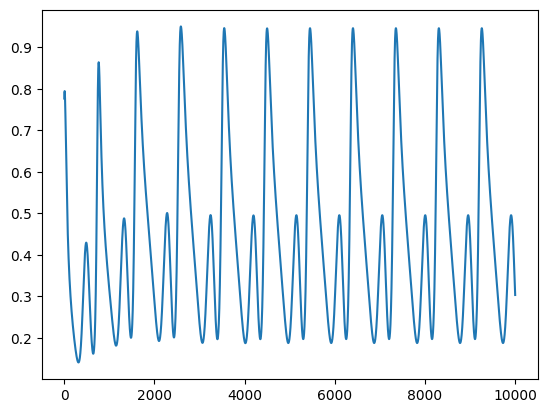

In [ ]:
plt.plot(np.abs(r2a**2))

In [ ]:
from itertools import combinations as comb

In [ ]:
e1 = thetas2[-1,N:N+300]

In [ ]:
A_ = 0
for a,b in comb(e1,2):
    a_ = np.exp(1j*(a+b))
    A_+=a_

In [ ]:
ea1 = np.mean(np.exp(1j*e1))
ea2 = np.mean(np.exp(2j*e1))

In [ ]:
e11 = (e1- np.angle(ea1)-np.pi) %(np.pi*2) - np.pi 

(array([58., 54., 29., 19., 15., 15., 16., 23., 37., 34.]),
 array([-1.26728206, -0.95981829, -0.65235452, -0.34489076, -0.03742699,
         0.27003677,  0.57750054,  0.8849643 ,  1.19242807,  1.49989183,
         1.8073556 ]),
 <BarContainer object of 10 artists>)

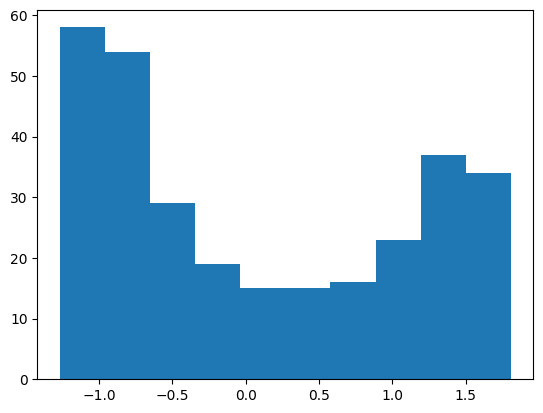

In [ ]:
plt.hist(e11)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/histograms.py:841: ComplexWarning: Casting complex values to real discards the imaginary part
  indices = f_indices.astype(np.intp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/axes/_axes.py:6793: ComplexWarning: Casting complex values to real discards the imaginary part
  bins = np.array(bins, float)  # causes problems if float16


(array([ 3443.,  1813.,  2935.,  3231.,  3090.,  2980.,  3108.,  3726.,
         5787., 14737.]),
 array([-9.99999998e-01, -7.99999999e-01, -5.99999999e-01, -3.99999999e-01,
        -1.99999999e-01,  5.28151189e-10,  2.00000000e-01,  4.00000000e-01,
         6.00000000e-01,  8.00000000e-01,  9.99999999e-01]),
 <BarContainer object of 10 artists>)

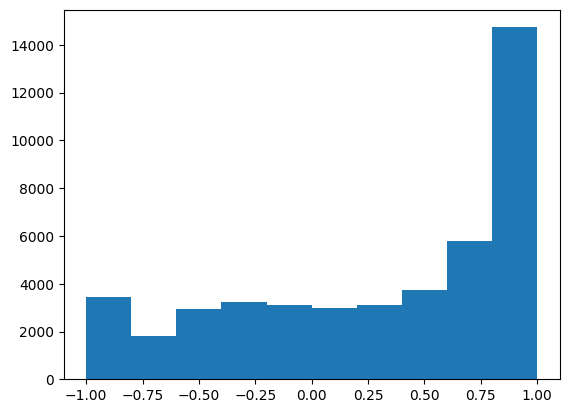

In [ ]:
plt.hist([np.exp(1j*(a+b)) for a,b in comb(e11,2)])

In [ ]:
[a+b for a,b in comb([-3,-2,-1,0,1,2,3],2)]

[-5, -4, -3, -2, -1, 0, -3, -2, -1, 0, 1, -1, 0, 1, 2, 1, 2, 3, 3, 4, 5]

In [ ]:
300*ea1**2 - 2*A_/300

(0.10050106199403785+0.282974056438249j)

In [ ]:
ea2

(0.10050106199332416+0.28297405643824036j)

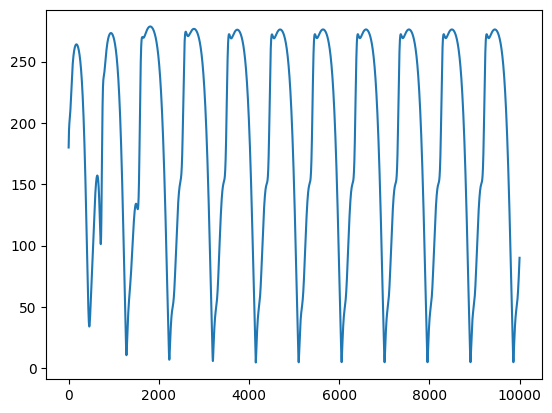

In [ ]:
plt.plot(np.abs( np.sum(np.exp(2j*thetas2[:,N:N+300]),axis=1)))

In [ ]:
plt.subplot(211)
plt.plot(thetas2[:,N:N+275]%(np.pi));
plt.xlim(0,2500)
plt.subplot(212)
plt.plot(thetas2[:,N+275:]%(np.pi));
plt.xlim(0,2500)

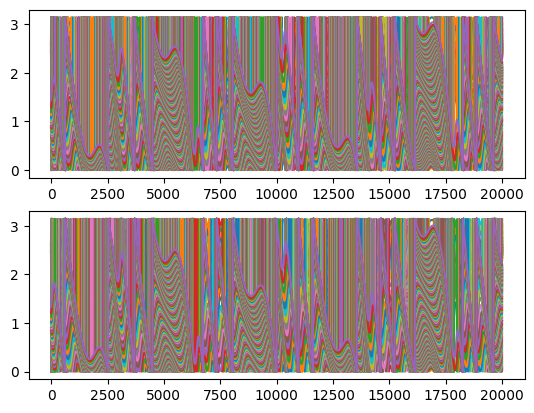

In [ ]:
plt.subplot(211)
plt.plot(thetas[:,N:N+275]%(np.pi));
plt.subplot(212)
plt.plot(thetas[:,N+275:]%(np.pi));

In [205]:
r1a = np.mean(np.exp(1j*thetas[:,N:N+int(N*(1+eta2)/2)]),axis=1)
r1b = np.mean(np.exp(1j*thetas[:,N+int(N*(1+eta2)/2):]),axis=1)

q1a = np.mean(np.exp(2j*thetas[:,N:N+int(N*(1+eta2)/2)]),axis=1)
q1b = np.mean(np.exp(2j*thetas[:,N+int(N*(1+eta2)/2):]),axis=1)

$Re^{i\psi} = \frac{1}{N} \sum{e^{i\theta}}= \frac{1+\eta_2}{2} \frac{2}{(N*(1+\eta_2))}\sum{e^{1i\theta_{i}}} + \frac{ 1-\eta_2}{2} \frac{2}{(N*(\eta_2-1))} \sum{-e^{1i\theta_{i}}} =  \frac{1+\eta_2}{2} re^{i\psi}-\frac{1-\eta_2}{2} re^{i\psi} = \eta_2 re^{i\psi}$  

$Qe^{i\phi} = Qe^{i2\psi} = \frac{1}{N} \sum{e^{2i\theta}}= \frac{1+\eta_2}{2} \frac{2}{(N*(1+\eta_2))}\sum{e^{2i\theta_{i}}} + \frac{1-\eta_2}{2} \frac{2}{(N*(1-\eta_2))} \sum{e^{2i\theta_{i}}} =  \frac{1+\eta_2}{2} qe^{i\phi} + \frac{1-\eta_2}{2} qe^{i\phi} = qe^{i\phi}$

In [ ]:
TT = np.linspace(-np.pi,np.pi,10000)

In [ ]:

def dist_abc(x, a, b, eta):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (1/2+eta/2)*(a_+a_.conjugate())+(1/2-eta/2)*(b_+b_.conjugate()))
    return f

In [ ]:

def dist_a(x, a):
    a_ = a*np.exp(1j*x)/(1-a*np.exp(1j*x))
    # b_ = b*np.exp(1j*x)/(1-b*np.exp(1j*x))
    f = 1/(2*np.pi) * (1+ (a_+a_.conjugate()))
    return f

In [ ]:
np.abs(r1a)[index]

0.9636363636363636

In [ ]:
np.abs(r1b)[index]

0.9733333333333334

In [ ]:
plt.plot()

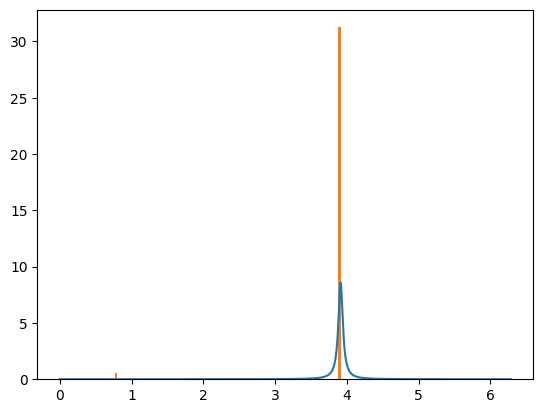

In [ ]:
index = -100
plt.plot(TT,np.abs(dist_a(TT,np.conj(r1a[index]))))
# plt.plot(TT,np.abs(dist_abc(TT,np.conj(r2[index]),np.conj(r22[index]),eta2)))
plt.hist(thetas[index,N:N+int(N*(eta2+1)/2)]%(2*np.pi),density=True,bins=100);

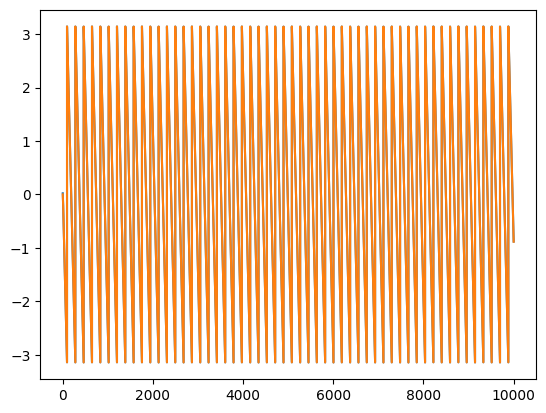

In [ ]:
plt.plot(t_,np.angle(Z1bs))
plt.plot(t_,np.angle(r1a))
# plt.plot(t_,np.angle(r1a))

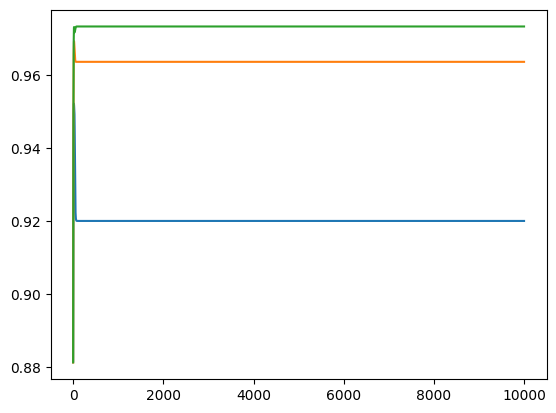

In [ ]:
plt.plot(t_,R2_S/eta2)
plt.plot(t_,np.abs(r1a))
plt.plot(t_,np.abs(r1b))


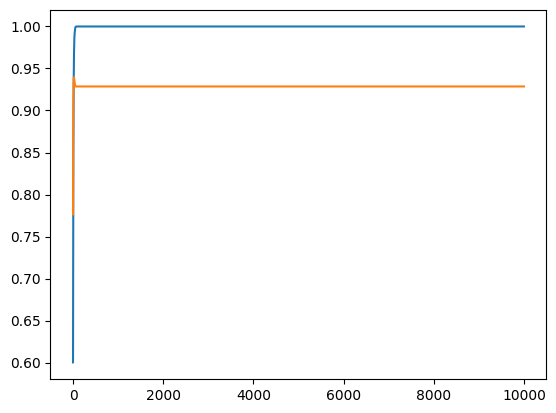

In [ ]:
plt.plot(t_,Q2_S)
plt.plot(t_,np.abs(r1a**2))

In [ ]:
AAA =np.sum([np.exp(1j*th) * dist_abc(th,(r2[index]),(r22[index]),eta2) for th in thetas[index,N:]])

In [ ]:
np.abs(AAA * (TT[1]-TT[0]))

0.007079581461226943

In [ ]:
R2_S[index]

0.07514871

In [ ]:
np.angle(R1_S)

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

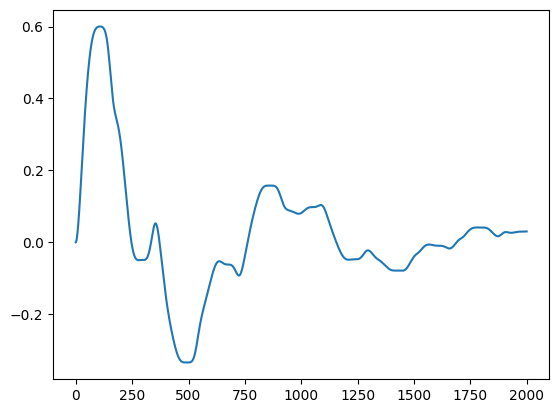

In [1326]:
# plt.plot(t_,(2*np.angle(Z1bs)-np.angle(Z2bs))%(np.pi*2))
plt.plot(t_,np.cos(2*np.angle(Z1bs))-np.cos(np.angle(Z2bs)))

# plt.plot(t_,)
# plt.plot(t_,np.angle(Z2bs))
# plt.plot(t,np.angle(a2s))
# plt.plot(t,np.angle(a1s))

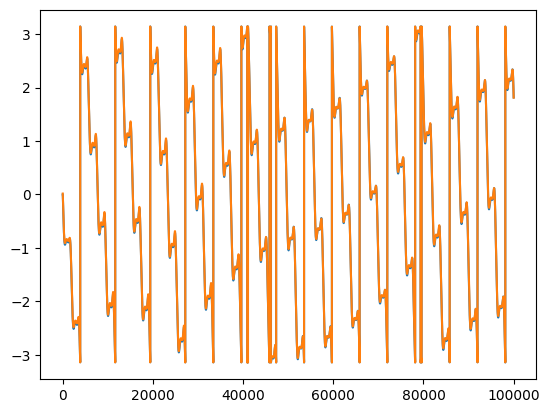

In [206]:
plt.plot(np.angle(Z1bs))
plt.plot(np.angle(r1a))

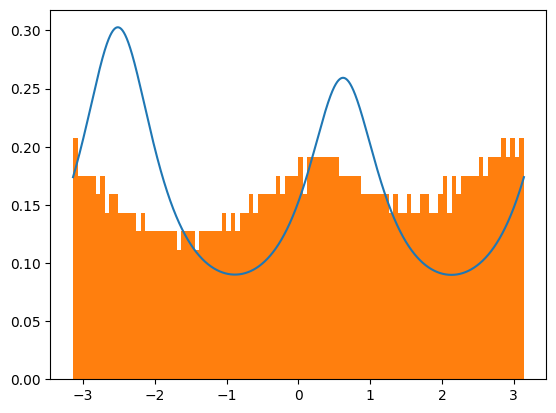

In [1294]:
index = 8000
plt.plot(TT,np.abs(dist_abc(TT,np.conj(r1a[index]),np.conj(r1b[index]),eta2)))
# plt.plot(TT,np.abs(dist_abc(TT,np.conj(r2[index]),np.conj(r22[index]),eta2)))
plt.hist((thetas[index,N:]+np.pi)%(2*np.pi)-np.pi,density=True,bins=100);

(array([11.,  4.,  4.,  3.,  3.,  3.,  3.,  2.,  3.,  2.,  3.,  3.,  2.,
         2.,  4.,  2.,  4.,  2.,  3.,  3.,  4.,  3.,  4.,  3.,  4.,  3.,
         6.,  4.,  4.,  5.,  5.,  6.,  6.,  6.,  6.,  6.,  7.,  7.,  7.,
         7.,  8.,  7.,  6.,  7.,  5.,  6.,  5.,  5.,  4.,  4.,  5.,  5.,
         5.,  5.,  6.,  8.,  8.,  7.,  9.,  9.,  9.,  9.,  8.,  8.,  9.,
         8.,  6.,  8.,  6.,  6.,  6.,  6.,  6.,  4.,  6.,  4.,  5.,  4.,
         4.,  4.,  4.,  4.,  3.,  3.,  4.,  3.,  4.,  3.,  3.,  4.,  2.,
         4.,  2.,  4.,  4.,  3.,  4.,  5.,  5., 13.]),
 array([-9.99998430e-01, -9.79998849e-01, -9.59999269e-01, -9.39999688e-01,
        -9.20000108e-01, -9.00000527e-01, -8.80000947e-01, -8.60001366e-01,
        -8.40001786e-01, -8.20002205e-01, -8.00002625e-01, -7.80003044e-01,
        -7.60003464e-01, -7.40003883e-01, -7.20004303e-01, -7.00004722e-01,
        -6.80005142e-01, -6.60005561e-01, -6.40005980e-01, -6.20006400e-01,
        -6.00006819e-01, -5.80007239e-01, -5.60007658e

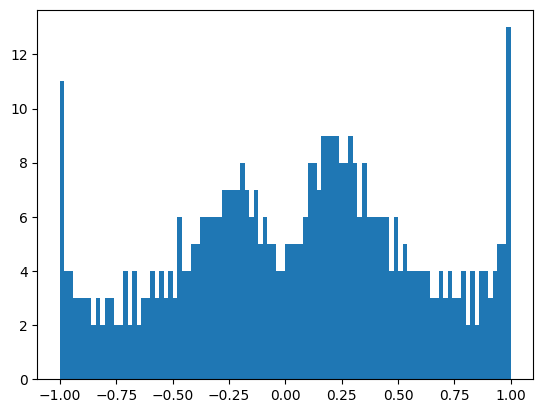

In [ ]:
plt.hist(np.cos((thetas[index,N:])),bins=100)#%(2*np.pi)-np.pi,density=True,bins=100);

In [ ]:
np.angle(np.exp(1j*(-3*np.pi)))

-3.1415926535897927

In [199]:

plt.imshow((thetas[:,N:]-np.angle(Z1bs)+np.pi)%(2*np.pi)-np.pi,origin='lower',cmap='bwr')
plt.gca().set_aspect('auto')

ValueError: operands could not be broadcast together with shapes (100000,4000) (100000,) 

(8000.0, 10000.0)

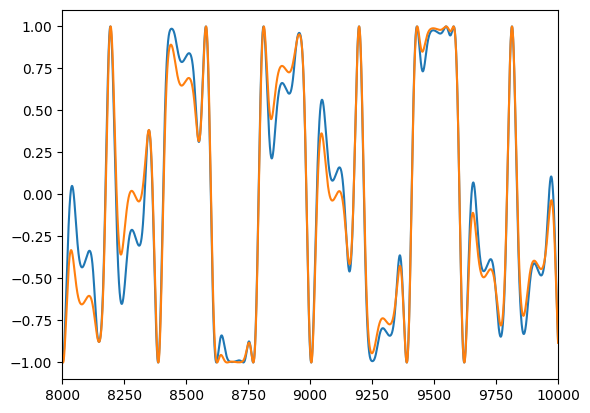

In [197]:
plt.plot(t_,np.cos(np.angle(Z2bs)))
plt.plot(t_,np.cos(np.angle(Z1bs)*2))
plt.xlim(8000,10000)

Text(0.5, 1.0, '$Re^{i\\psi}=\\dfrac{1}{N}\\sum{e^{1i\\theta}}$,$Qe^{i\\phi}=\\dfrac{1}{N}\\sum{e^{2i\\theta}}$')

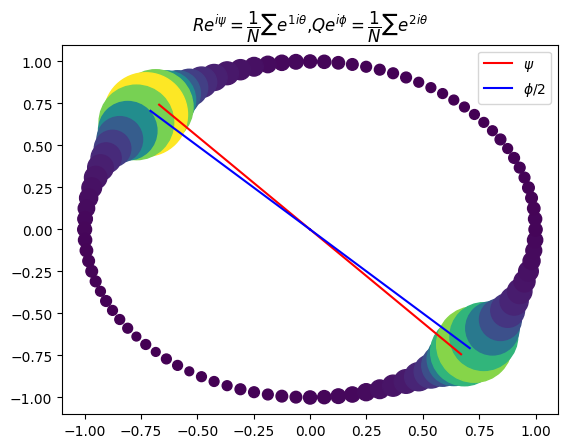

In [203]:
index = -200

bins = np.linspace(0,2*np.pi,101)
h,b =np.histogram(thetas[index,N:]%(2*np.pi),bins=bins,density=False)
plt.scatter(np.cos(b[1:]),np.sin(b[1:]),s=h*10,c=h)
plt.plot([0,np.cos(np.angle(Z1bs[index]))], [0,np.sin(np.angle(Z1bs[index]))],color='red',label=r'$\psi$')
plt.plot([0,np.cos(np.angle(Z1bs[index])+np.pi)], [0,np.sin(np.angle(Z1bs[index])+np.pi)],color='red')
plt.plot([0,np.cos(np.angle(Z2bs[index])/2)], [0,np.sin(np.angle(Z2bs[index])/2)],color='blue')
plt.plot([0,np.cos(np.angle(Z2bs[index])/2+np.pi)], [0,np.sin(np.angle(Z2bs[index])/2+np.pi)],color='blue',label=r'$\phi/2$')
plt.legend()

plt.title(r'$Re^{i\psi}=\dfrac{1}{N}\sum{e^{1i\theta}}$,$Qe^{i\phi}=\dfrac{1}{N}\sum{e^{2i\theta}}$')

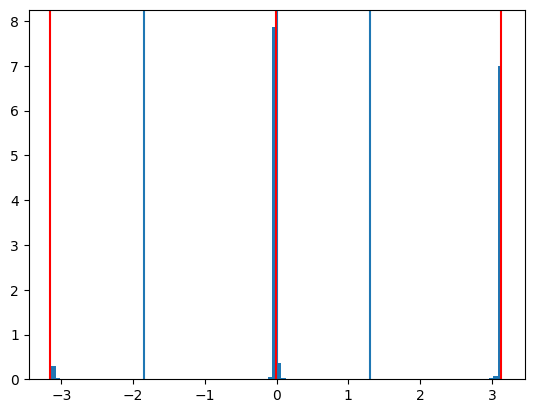

In [1330]:
index = -3000
plt.hist((thetas[index,N:]+np.pi - np.angle(Z1bs[index]))%(2*np.pi)-np.pi,density=True,bins=100);
# plt.hist((thetas[index,N:])%(2*np.pi),density=True,bins=100);
plt.axvline(np.angle(r1a[index])-np.angle(Z1bs[index]))
plt.axvline(np.angle(r1b[index])-np.angle(Z1bs[index]))
plt.axvline(np.angle(Z1bs[index])-np.angle(Z1bs[index]))
plt.axvline(np.angle(Z2bs[index])/2-np.angle(Z1bs[index]),color='red')
plt.axvline(np.angle(Z2bs[index])/2-np.pi-np.angle(Z1bs[index]),color='red')
plt.axvline(np.angle(Z2bs[index])/2+np.pi-np.angle(Z1bs[index]),color='red')

In [ ]:
bins = np.linspace(0,2*np.pi,101)
np.histogram(thetas[index,N:]%(2*np.pi),bins=bins,density=True)

(array([0.06366198, 0.06366198, 0.12732395, 0.22281692, 0.31830989,
        3.24676084, 2.67380304, 0.66845076, 0.25464791, 0.15915494,
        0.09549297, 0.06366198, 0.03183099, 0.03183099, 0.03183099,
        0.03183099, 0.        , 0.03183099, 0.        , 0.03183099,
        0.        , 0.03183099, 0.        , 0.        , 0.        ,
        0.03183099, 0.        , 0.        , 0.03183099, 0.        ,
        0.        , 0.        , 0.        , 0.03183099, 0.        ,
        0.        , 0.        , 0.03183099, 0.        , 0.        ,
        0.03183099, 0.        , 0.03183099, 0.        , 0.03183099,
        0.        , 0.03183099, 0.03183099, 0.03183099, 0.06366198,
        0.06366198, 0.09549297, 0.15915494, 0.25464791, 0.38197186,
        2.70563403, 2.19633821, 0.50929582, 0.22281692, 0.12732395,
        0.09549297, 0.03183099, 0.03183099, 0.03183099, 0.03183099,
        0.03183099, 0.        , 0.03183099, 0.        , 0.        ,
        0.03183099, 0.        , 0.        , 0.  

<BarContainer object of 500 artists>

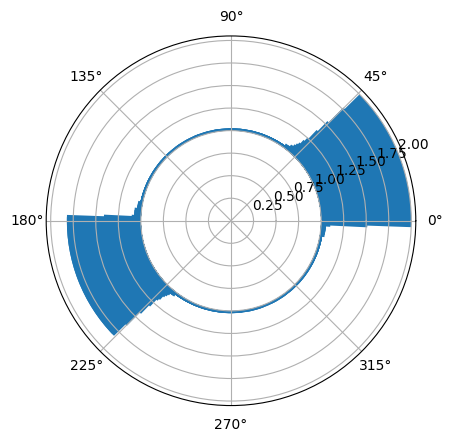

In [ ]:
plt.subplot(projection='polar')
bins = np.linspace(0,2*np.pi,501)
h,b =np.histogram(thetas[index,N:]%(2*np.pi),bins=bins,density=False)
# plt.hist(thetas[index,N:]%(2*np.pi),bins=100,density=True);
plt.bar(b[1:],h/np.max(h),bottom=1)

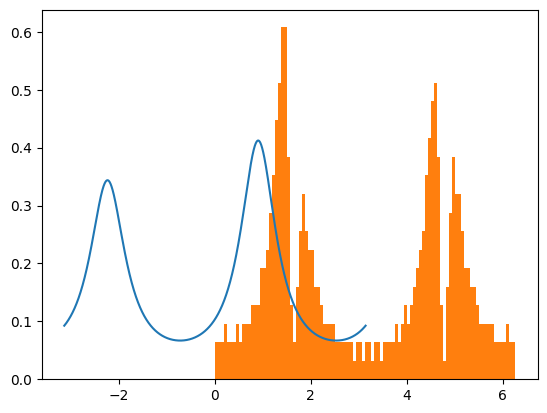

In [ ]:
index = 6000
# plt.plot(TT,np.abs(dist_abc(TT,np.conj(r1a[index]),np.conj(r1b[index]),eta2)))
plt.plot(TT,np.abs(dist_abc(TT,np.conj(r2[index]),np.conj(r22[index]),eta2)))
plt.hist(thetas[index,N:]%(2*np.pi),density=True,bins=100);

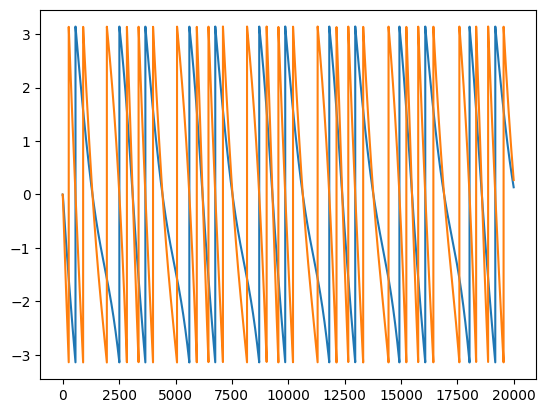

In [ ]:
plt.plot(np.angle(Z1as))
plt.plot(np.angle(Z2as))

In [ ]:
QQQ = (r1a+r1b)**2 /2 + (r1a-r1b)**2 /2 *eta2

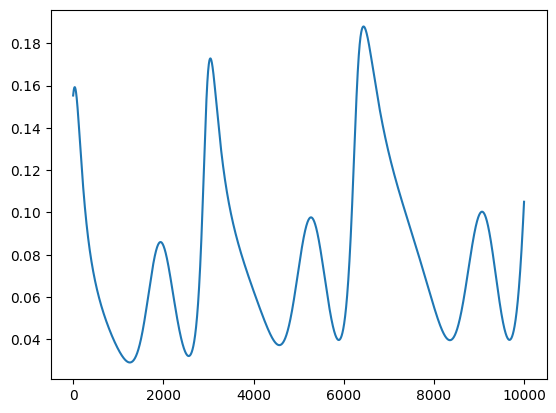

In [ ]:
plt.plot(np.abs(QQQ))

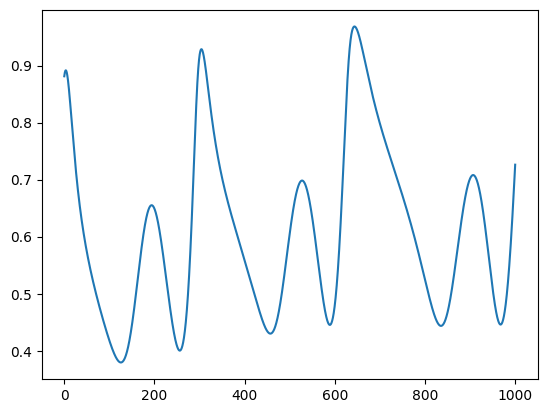

In [ ]:
plt.plot(t_,np.abs(r1a))

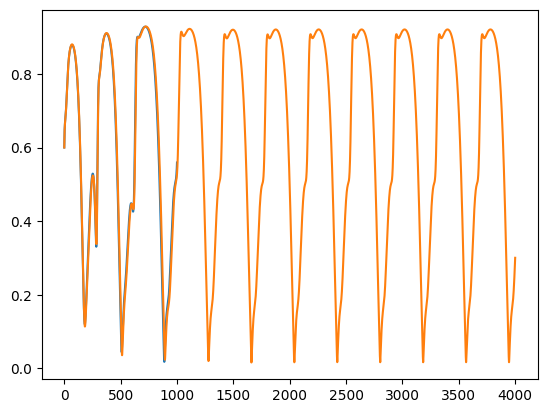

In [ ]:
plt.plot(t_,np.abs(q1a))
plt.plot(4*t_,np.abs(q2a))


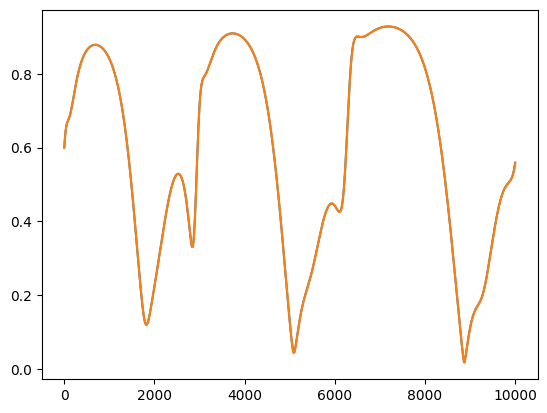

In [ ]:
# plt.plot(np.abs(r1a))
plt.plot(np.abs(q1a))
plt.plot(Q2_S[N])

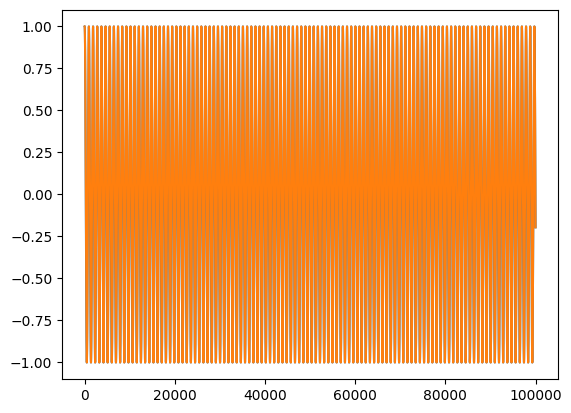

In [ ]:
plt.plot(np.cos(2*np.angle(r1a)))
plt.plot(np.cos(np.angle(q1a)))

(0.0, 1000.0)

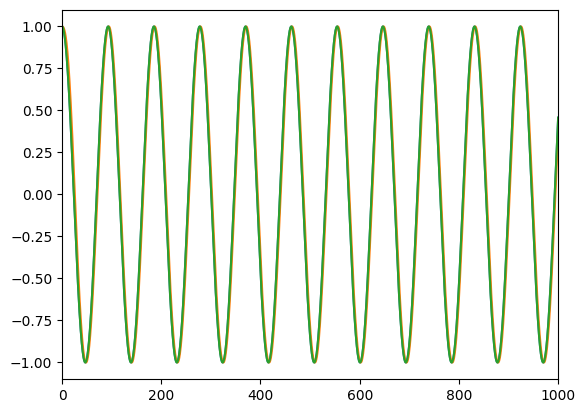

In [ ]:
plt.plot(t_,np.cos(np.angle(Z2as)))
plt.plot(t_,np.cos(2*np.angle(r1a)))
plt.plot(t_,np.cos(2*np.angle(Z1as)))
plt.xlim(0,1000)

(0.0, 1000.0)

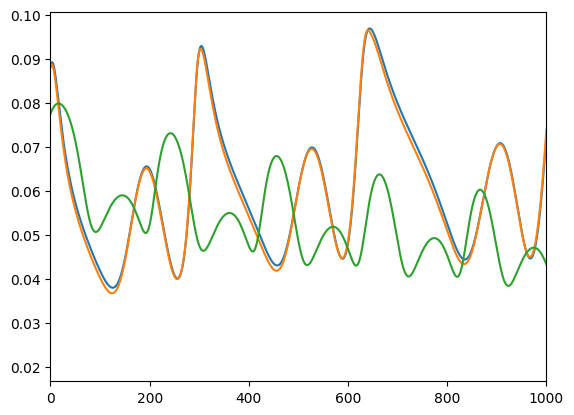

In [ ]:
plt.plot(t_, eta2*np.abs(r1a))
plt.plot(t_,R2_S)
plt.plot(t,R2s)
plt.xlim(0,1000)

In [ ]:
Q2_ss = np.mean(np.exp(2j*thetas[:,N:]),axis=1)

In [ ]:
N = 500

In [ ]:
thetas[:,:].shape

(10000, 1000)

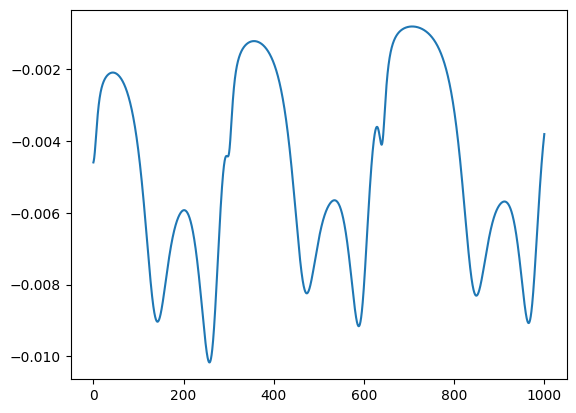

In [ ]:
plt.plot(t_,np.sin(np.angle(r1a)-np.angle(r1b)))
# plt.plot(t_,)
# plt.plot(t_,np.angle(Q2_ss))

In [ ]:
r1a.shape

(10000,)

In [ ]:
r1a.shape

(10000, 275)

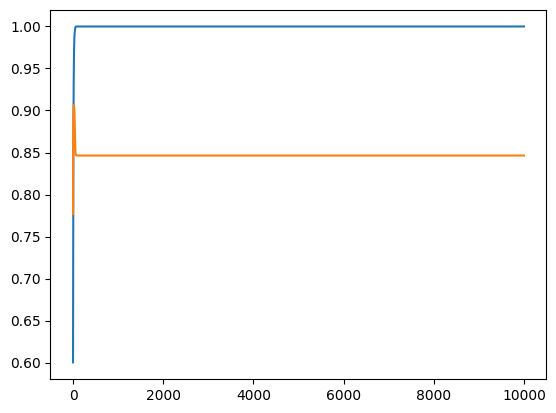

In [ ]:
plt.plot(t_,Q2_S)
plt.plot(t_,(R2_S/eta2)**2)

In [ ]:
eta2

0.1

In [ ]:
eta1 = 0.1
eta2 = 0.1


In [ ]:
m1.ppf(1)

array(inf)

## OA ansatz와 시뮬레이션의 차이 문제
1. OA ansatz $\eta_1$ $\eta_2$의 결과는 시뮬레이션에선 $\eta_1/2$ $\eta_2/2$ 해주어야 함

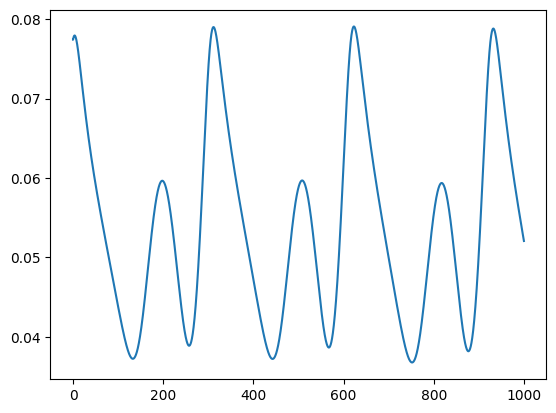

In [ ]:
# plt.plot(t,R2s)
plt.plot(t_,R2_S)
# plt.plot(t_,Q2_S[N])

Text(0.5, 1.0, '$\\alpha=1.2,\\beta=0.8,\\eta_1=0.2,\\eta_2=0.1$')

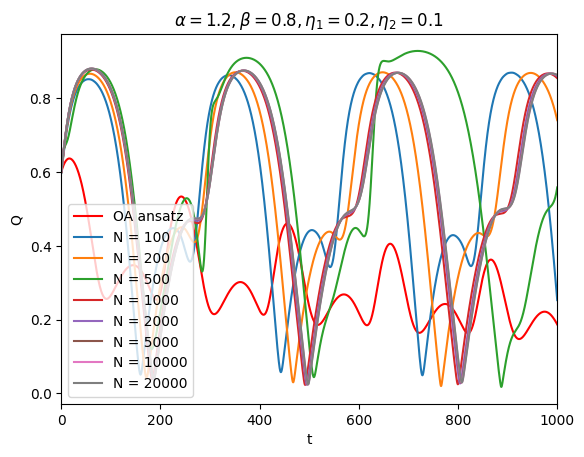

In [ ]:
# plt.plot(t,R1**2)
# plt.plot(t,R2**2)
plt.plot(t,Q2s,color='red',label='OA ansatz')
plt.xlim(0,1000)
for N in [100,200,500,1000,2000,5000,10000,20000]:
    plt.plot(t_,Q2_S[N],label = f'N = {N}')
# plt.loglog()

plt.legend()
plt.xlabel('t')
plt.ylabel('Q')
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')


(0.0, 250.0)

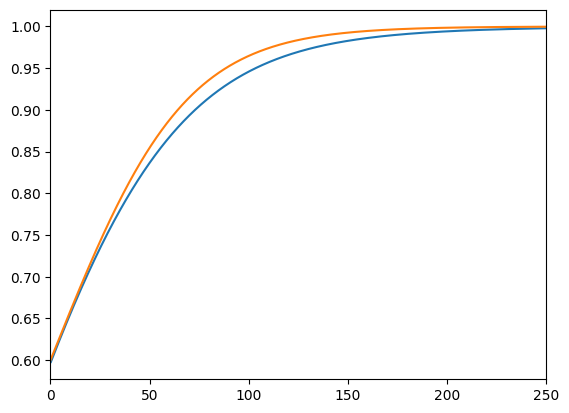

In [ ]:
# plt.plot(t,R1**2)
# plt.plot(t,R2**2)
plt.plot(t_,Q2_S)
plt.plot(t,Q2s)
plt.xlim(0,250)
# for N in [500,1000,2000,5000,10000]:
    # plt.plot(t,Q2_S[N])
# plt.loglog()

(0.0, 250.0)

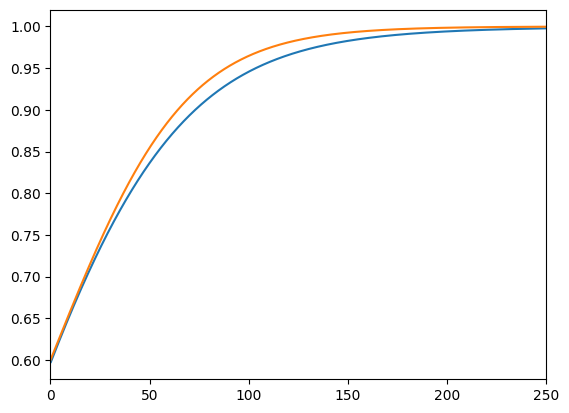

In [ ]:
plt.plot(t_,Q2_S)
plt.plot(t,Q2s)
plt.xlim(0,250)

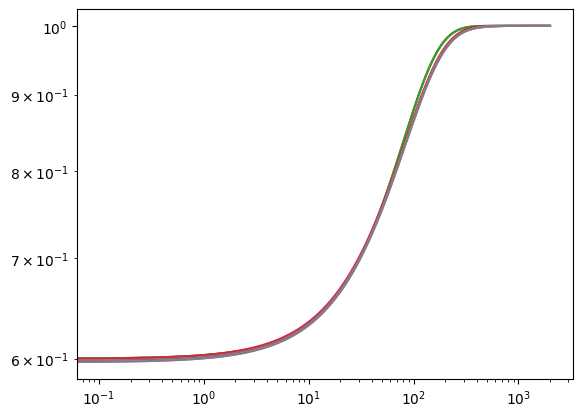

In [ ]:
plt.plot(t,R1**2)
plt.plot(t,R2**2)
plt.plot(t,Q2s)
plt.loglog()

for N in [500,1000,2000,5000,10000]:
    plt.plot(t,Q2_S[N])
# plt.plot(t,Q2_S)

In [ ]:
args = beta,alpha,eta1,eta2


/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_46333/1849525670.py:66: UserWarning: The following kwargs were not used by contour: 'color'
  ax.contourf(Y.T,X.T,M.T,color=M.T,zorder=3,levels=[0-1e-4,0+1e-4])


<Figure size 3200x2400 with 0 Axes>

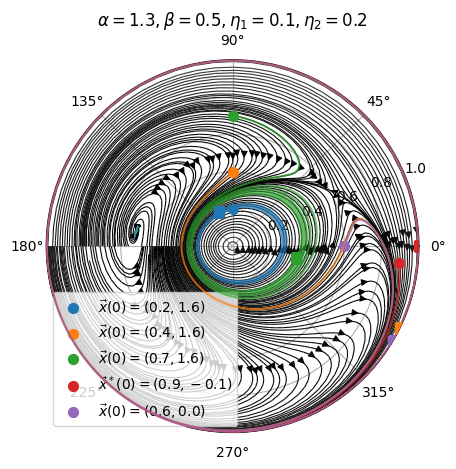

In [208]:
alpha = 1.3
beta = 0.5
eta1 = 0.1
eta2 = 0.2

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
plt.figure(dpi=500)


fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.sca(ax)

u0s = [[0.2,np.pi/2],[0.4,np.pi/2],[0.7,np.pi/2],[0.9,-0.1],[0.6,0.]]
for i,u0 in enumerate(u0s):

	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(args,))
	if i == 3:
		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
	else:	
		c = plt.scatter(u[0,1]%(np.pi*2),u[0,0],s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]),zorder=5)
	plt.scatter(u[-1,1]%(np.pi*2),u[-1,0],s=50,marker='s',zorder=7,color=c.get_facecolor())
	plt.plot(u[:,1],u[:,0],alpha=0.7,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))


xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
# plt.xlabel('x',fontsize=15)
# plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')


plt.legend(loc=3)
x = np.linspace(0,1.5,200)
y = np.linspace(-np.pi,np.pi,400)
X,Y = np.meshgrid(x,y)

U,V = myFun3([X,Y],0,args)
M = (np.hypot(U,V))
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

xs = np.linspace(-3,-1e-5,1000)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y)
# Q = plt.quiver(y,x,V,U,M,scale=20,pivot='mid',cmap='jet',zorder=3,alpha=0.7)

# plt.colorbar()
# plt.plot(np.angle(r2),np.abs(r2),zorder=5,color='blue')
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()
ax = plt.gca()
ax.streamplot(Y.T,X.T,V.T,U.T,color=M.T,zorder=3,density=2,cmap = 'gray',linewidth=0.8,broken_streamlines=False,)
ax.contourf(Y.T,X.T,M.T,color=M.T,zorder=3,levels=[0-1e-4,0+1e-4])
ax.axhline(1,color='RED')
plt.tight_layout()

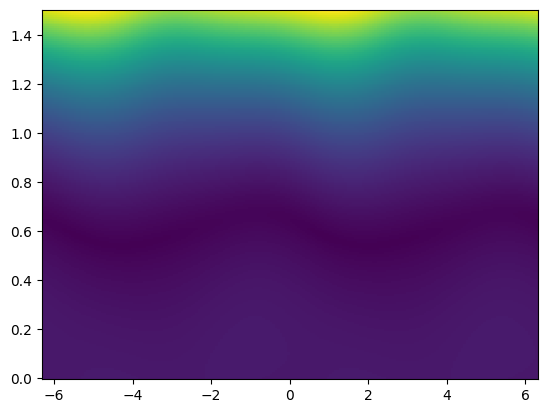

In [ ]:
plt.pcolormesh(Y.T,X.T,M.T)

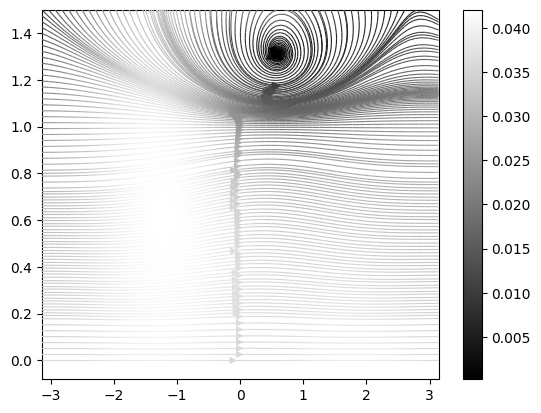

In [1334]:
plt.streamplot(Y.T,X.T,V.T,U.T,color=M.T,zorder=3,density=2,cmap = 'gray',linewidth=0.8,broken_streamlines=False,)
plt.colorbar()

In [ ]:
# beta = 0.7
# alpha = 1.2
# eta1 = 0.1
# eta2 = 0.05

# alpha = 1.2
# beta = 0.3
# eta1 = 0.1
# eta2 = 0.05

args = beta,alpha,eta1,eta2
t = np.arange(0,6000,0.1)
# y = np.linspace(0,0,1)
# x = np.linspace(0,2*np.pi,5)
# X,Y = np.meshgrid(x,y)
# fx = 0.5
# fy = 0.5


# u0s = [[1-1e-3,0],[0 + 1e-3,1],[fx,fy]]
# u0s = [[1,0.5],[0,0],[0.2,0],[0.3,0],[0.6, 0],[0.9114966199929684-0.1,3.072208206306462+0.1]]
# u0s = [[x_,y_] for x_,y_ in zip(X.flatten(),Y.flatten()) ]
plt.figure(dpi=500)


# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# plt.sca(ax)
# for i,u0 in enumerate(u0s):

# 	u = RK4(myFun2,np.array(u0,dtype=float),t,args=(args,))
# 	if i == 3:
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}^*(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	else:	
# 		c = plt.scatter(u[0,0],u[0,1]%(np.pi*2),s=50,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))
# 	plt.scatter(u[-1,0],u[-1,1]%(np.pi*2),s=50,marker='s',zorder=7,color=c.get_facecolor())
# 	plt.scatter(u[:,0],u[:,1]%(np.pi*2),s=1,alpha=0.8,zorder=6,color=c.get_facecolor())#,label=r'$\vec{x}(0)=(%.1f,%.1f)$'%(u0[0],u0[1]))

# plt.legend()
x = np.linspace(0.0,1,500)
y = np.linspace(0,3.*np.pi,500)
X,Y = np.meshgrid(x,y)

U,V = myFun2([X,Y],0,args)
M = (np.hypot(U,V))

XX = X*np.cos(Y)
YY = X*np.sin(Y)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# V = 0*V
xs = np.linspace(-3,-1e-5,1000)
# U = U / np.sqrt(U**2 + V**2);
# V = V / np.sqrt(U**2 + V**2);

# plt.axhline(0,color='black')
# plt.plot(xs,-np.log(-xs),color='black')
# plt.plot(x,xdot(x,y)
# Q = plt.quiver(y,x,V,U,M,scale=20,pivot='mid',cmap='jet',zorder=3,alpha=0.7)

# plt.colorbar()
plt.ylim(0,1.0)
plt.xlim(0,2*np.pi)
# plt.legend()

plt.streamplot(XX.T,YY.T,V.T,U.T,zorder=3,cmap='magma',broken_streamlines=False)
plt.contourf(XX.T,YY.T,V.T,U.T,zorder=3,cmap='magma',level=[0-1e-2,0+1e-2])
plt.axhline(1,color='RED')

xs = np.linspace(-10,10,1000)
# plt.plot(xs,F(xs))
ax.grid(True)
ax.minorticks_on()
plt.title(rf'$\alpha={alpha},\beta={beta},\eta_1={eta1},\eta_2={eta2}$')
# plt.plot(-1,0,'o',ms=10,markeredgewidth=2,markerfacecolor='white')
plt.xlabel('x',fontsize=15)
plt.ylabel('y',fontsize=15)
# plt.legend()

# qk = plt.quiverkey(Q, 0.9, 0.9, 1, r'$2 \frac{m}{s}$', labelpos='E',
#                    coordinates='figure')



TypingError: Failed in nopython mode pipeline (step: nopython frontend)
No implementation of function Function(<built-in function array>) found for signature:
 
 >>> array(list(array(float64, 2d, C))<iv=None>)
 
There are 2 candidate implementations:
  - Of which 2 did not match due to:
  Overload in function 'impl_np_array': File: numba/np/arrayobj.py: Line 5421.
    With argument(s): '(list(array(float64, 2d, C))<iv=None>)':
   Rejected as the implementation raised a specific error:
     TypingError: Failed in nopython mode pipeline (step: nopython frontend)
   No implementation of function Function(<intrinsic np_array>) found for signature:
    
    >>> np_array(list(array(float64, 2d, C))<iv=None>, none)
    
   There are 2 candidate implementations:
         - Of which 2 did not match due to:
         Intrinsic in function 'np_array': File: numba/np/arrayobj.py: Line 5395.
           With argument(s): '(list(array(float64, 2d, C))<iv=None>, none)':
          Rejected as the implementation raised a specific error:
            TypingError: array(float64, 2d, C) not allowed in a homogeneous sequence
     raised from /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/core/typing/npydecl.py:482
   
   During: resolving callee type: Function(<intrinsic np_array>)
   During: typing of call at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/np/arrayobj.py (5432)
   
   
   File "../../../../../Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/np/arrayobj.py", line 5432:
       def impl(object, dtype=None):
           return np_array(object, dtype)
           ^

  raised from /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numba/core/typeinfer.py:1091

During: resolving callee type: Function(<built-in function array>)
During: typing of call at /var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_7988/1070443291.py (39)


File "../../../../../var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_7988/1070443291.py", line 39:
<source missing, REPL/exec in use?>


<Figure size 3200x2400 with 0 Axes>

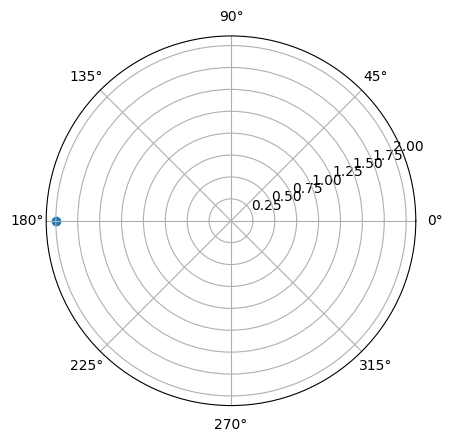

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.scatter(np.pi,2)